In [1]:
import mediapipe as mp
import cv2
import pandas as pd
import numpy as np
from tkinter import *
from PIL import Image,ImageTk

import csv
import os

from app.core.PoseHelper import PoseHelper
from app.core.SugesstionBuilder import SuggestionBuilder
import time

In [2]:
poses = []
names = []
images = []

In [3]:
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(
    static_image_mode=False, min_detection_confidence=0, model_complexity=2
)

In [4]:
suggester = SuggestionBuilder(mp_pose)
window = Tk()

In [5]:
import os

print(os.getcwd())
for pose_name in os.listdir("app/data/suryanamaskarsteps/"):
        names.append(pose_name)
names.sort()
for i in range(len(names)):
        pose_dir_path = os.path.join("app/data/suryanamaskarsteps/", names[i])
        step = PoseHelper(pose_dir_path,mp_pose=mp_pose,pose=pose,mp_drawing=mp_drawing)
        step.detect_keypoints(verbose=False)
        step.calculate_angles()
        poses.append(step)
        
        img = Image.open(pose_dir_path)
        w,h = img.size

        images.append(ImageTk.PhotoImage(img.resize((500,int(h*500/w)))))#)cv2.imread(pose_dir_path))
print(names)

c:\Users\cosmo\Projects\YogaPoseHelper
['01.pranamasana.jpg', '02.hastauttasana.jpg', '03.padasana.jpg', '04.ashwasanchalanasana.jpg', '05.chaturangadandasana.jpg', '06.astanganamaskara.jpg', '07.bhujangasana.jpg', '08.parvatasana.jpg', '09.ashwasanchalanasana.jpg', '10.padasana.jpg', '11.hastauttasana.jpg', '12.pranamasana.jpg']


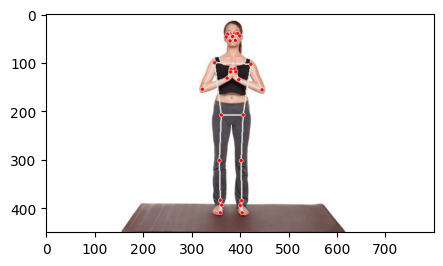

In [6]:
pose_index = 0 # next pose index
ideal = poses[pose_index]
ideal_arms_and_angles = ideal.arms_and_angles
pose_name = names[pose_index]
ideal.plot_keypoints2d()

In [7]:
# GUI Code

window.title("Pose Helper")
window.state('zoomed')

#text box
text_label1 = Label(window,text="Ideal Pose",font=("Comic Sans",50))
text_label1.grid(column=0,row=0, sticky="nsew")

text_label2 = Label(window,text="Live Video",font=("Comic Sans",50))
text_label2.grid(column=1,row=0, sticky="nsew")

img_label = Label(window,image=images[0])
img_label.grid(row=1,column=0, sticky="nsew")


live_video_label = Label(window,image=images[0])
live_video_label.grid(row=1,column=1, sticky="nsew")



# create a frame with fixed size
frame = Frame(window, height=200, width=500)
frame.pack_propagate(0) # don't shrink or expand
frame.grid(row=2, column=0, columnspan=2)

suggestions_label = Label(frame,text="suggestions\n1\n2",anchor='n',bg='red')
suggestions_label.pack(fill=BOTH, expand=1) # fill the frame



window.grid_rowconfigure(0, weight=1)
window.grid_rowconfigure(1, weight=1)
window.grid_rowconfigure(2, weight=2)
window.grid_columnconfigure(0, weight=1)
window.grid_columnconfigure(1, weight=1)

In [8]:
# TODO - make seperate thread for tts so it doesn't block main execution
# import pyttsx3

# def speak_text(text: str):
#     engine = pyttsx3.init()
#     engine.say(text)
#     engine.runAndWait()
#     return engine


In [9]:
# from playsound import playsound
# playsound("C:\\Projects\\YogaPoseHelper\\app\\media\\sound\\beep.mp3")
# speak_text("hello")

In [10]:
# speak_text("pranamasana")


In [11]:
cap = cv2.VideoCapture(0)

In [12]:
quit = False
def quit_func(*args):
    global quit
    quit = True
    print("quitting")
    cap.release()
    window.destroy()
window.bind("q",quit_func)
window.protocol("WM_DELETE_WINDOW",quit_func)

''

In [13]:
angle_error_threshold = 15

In [14]:
from app.core.graphics.graphics_assistant import draw_error_landmarks_2d


n = len(poses)
start_time = time.time() - 6
print(start_time)
pose_index = -1


def update_live():
    global quit, start_time, pose_index, poses, n, images, names, ideal_arms_and_angles, live_video_label, cap, pose_name, img_label
    if cap.isOpened():
        success, frame = cap.read()
        # print(success)
        end_time = time.time()
        # if end_time - start_time >= 6:
        #     pose_index += 1
        #     start_time = end_time
        #     ideal = poses[pose_index % n]
        #     ideal_arms_and_angles = ideal.arms_and_angles
        #     pose_name = names[pose_index % n]

        #     img_label.configure(image=images[pose_index % n])
        #     img_label.image = images[pose_index % n]
        # playsound("app/media/sound/beep.mp3")
        # engine = speak_text(pose_name.split(".")[1])

        if success:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = pose.process(frame)

            if results.pose_landmarks:
                helper = PoseHelper(
                    img=frame, mp_pose=mp_pose, pose=pose, mp_drawing=mp_drawing
                )
                helper.detect_keypoints(verbose=False)
                helper.calculate_angles()
                arms_and_angles = helper.arms_and_angles
                n = len(arms_and_angles)
                arms_and_angles_diff = PoseHelper.calculate_angle_differences(
                    ideal_arms_and_angles, arms_and_angles, n
                )

                suggestion_text = suggester.get_suggestions(arms_and_angles_diff,angle_error_threshold=angle_error_threshold)
                suggestions_label.configure(text=suggestion_text)

                # draw the landmarks
                draw_error_landmarks_2d(
                    arms_and_angles_diff=arms_and_angles_diff,
                    img=frame,
                    landmark_list=results.pose_landmarks,
                    pronounce_error_by=5,
                    connections=mp_pose.POSE_CONNECTIONS,
                    verbose=False,
                )

            # convert back to bgr
            # frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

            # put the pose name on the image
            cv2.putText(
                frame, pose_name, (5, 20), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 0, 0), 2
            )

            live_img = ImageTk.PhotoImage(Image.fromarray(frame))
            live_video_label.configure(image=live_img)
            live_video_label.image = live_img

    window.update()  # to refresh the window

    window.after(
        10, update_live
    )  # to add our custom update function to the queue to be executed


update_live()
window.mainloop()

1693511796.2659953
quitting
